In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
import statsmodels
import statsmodels.api as sm

In [4]:
#using the Quantopian research environment 
tickers = ['T', 'VZ']
data = get_pricing(symbols(tickers), start_date='2006-1-1', end_date='2019-7-1', 
                   fields='close_price', frequency='daily')
data.columns = [ticker.symbol for ticker in data.columns]
data.index.name = 'Date'

In [92]:
data.tail()

,T,VZ
Date,,
2019-06-25 00:00:00+00:00,32.55,58.000
2019-06-26 00:00:00+00:00,32.54,57.000
2019-06-27 00:00:00+00:00,32.98,57.240
2019-06-28 00:00:00+00:00,33.49,57.125
2019-07-01 00:00:00+00:00,33.44,56.680


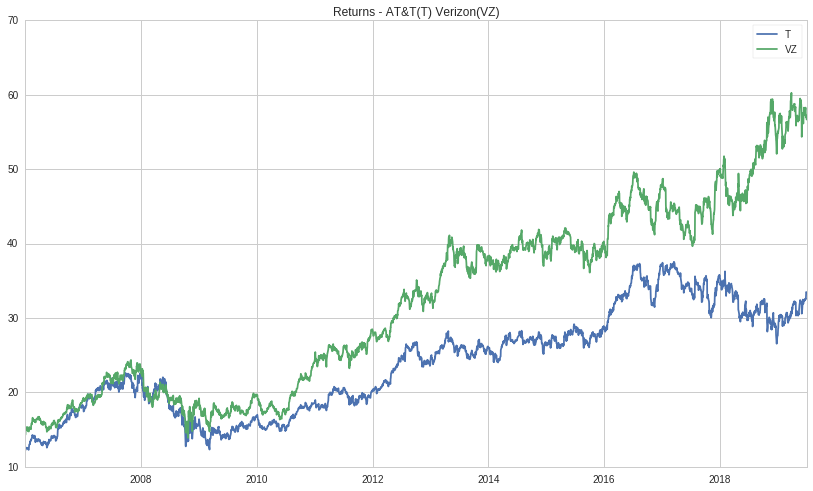

In [91]:
#Plotting the returns
plt.plot(data.index,data[tickers[0]])
plt.plot(data.index,data[tickers[1]])
plt.legend()
plt.title("Return Plot - AT&T(T) Verizon(VZ)")

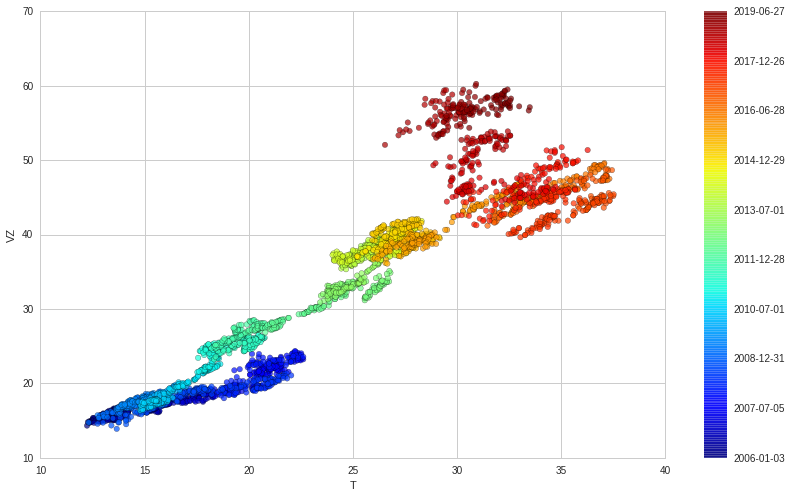

In [6]:
#Relation between two stocks' returns
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

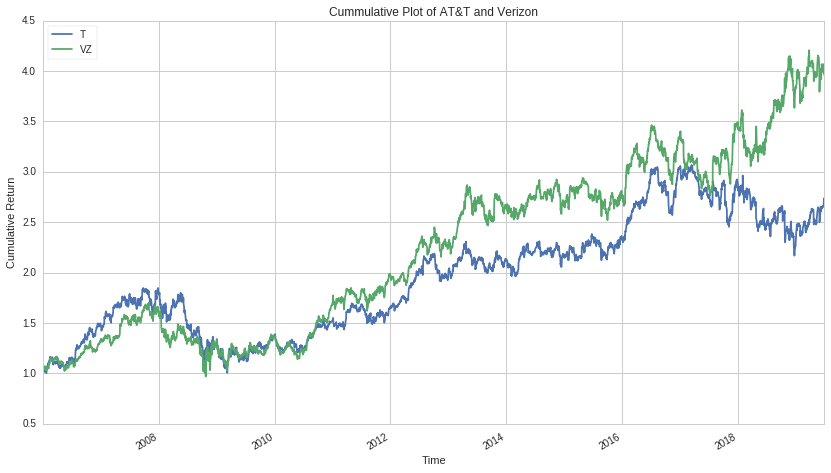

In [7]:
#Cummlativ returns plot
cumm_rtn = (1 + data.pct_change()).cumprod()
cumm_rtn.plot();
plt.ylabel('Cumulative Return');
plt.xlabel('Time');
plt.title('Cummulative Plot of AT&T and Verizon');

In [8]:
#Linear regression using a simple OLS
x = sm.add_constant(data[tickers[0]], prepend=False)
ols = sm.OLS(data[tickers[1]], x).fit()
beta = ols.params
y_fit = [x.min().dot(beta), x.max().dot(beta)]

In [9]:
print(ols.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.863     
Dependent Variable: VZ               AIC:                20000.9597
Date:               2019-07-24 18:31 BIC:                20013.2204
No. Observations:   3396             Log-Likelihood:     -9998.5   
Df Model:           1                F-statistic:        2.134e+04 
Df Residuals:       3394             Prob (F-statistic): 0.00      
R-squared:          0.863            Scale:              21.139    
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
T           1.6895     0.0116   146.0876   0.0000    1.6668    1.7122
const      -8.2556     0.2874   -28.7250   0.0000   -8.8191   -7.6921
-------------------------------------------------------------------
Omnibus:             593.231       Durbin-Watson:       

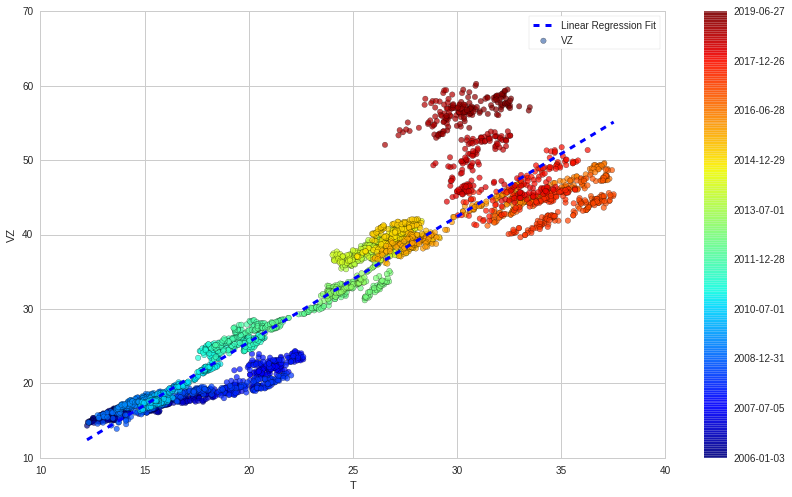

In [10]:
#Plotting regression line on the relation plot
colors = np.linspace(0.1, 1, len(data))
sc = plt.scatter(data[tickers[0]], data[tickers[1]], s=30, 
                 c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='Linear Regression Fit')
plt.legend()

cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::len(data)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

In [11]:
#Linear regression using Ski-learn
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True)
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [12]:
reg.fit(data[tickers[0]].reshape(-1,1), data[tickers[1]])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [13]:
#Printing the slope and intercept
print("The beta coefficient is {0} and \nThe intercept coefficient is {1}".format(reg.coef_, reg.intercept_))

The beta coefficient is [ 1.68950737] and 
The intercept coefficient is -8.25558771845


In [16]:
#Finding spread between AT&T and Verizon
spread = pd.DataFrame(data[tickers[1]] - beta[0] * data[tickers[0]] - beta[1])
spread.columns = ['in-sample']

In [15]:
spread.head()

,in-sample
Date,
2006-01-03 00:00:00+00:00,1.904776
2006-01-04 00:00:00+00:00,2.161514
2006-01-05 00:00:00+00:00,2.311172
2006-01-06 00:00:00+00:00,2.044056
2006-01-09 00:00:00+00:00,2.073444


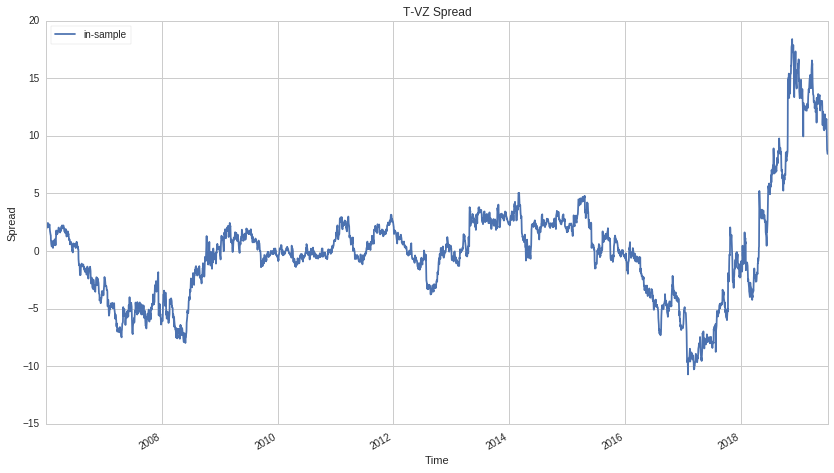

In [17]:
#Plotting the spread
spread.plot();
plt.xlabel('Time');
plt.ylabel('Spread');
plt.title('T-VZ Spread')

In [18]:
#Augmented dickey-fuller test, fail to reject null, stationary time series
adf = statsmodels.tsa.stattools.adfuller(spread['in-sample'], maxlag=1)
print('ADF test statistic: {:.03f}').format(adf[0])
print('p-value: {:.03f}').format(adf[1])

ADF test statistic: -2.066
p-value: 0.258


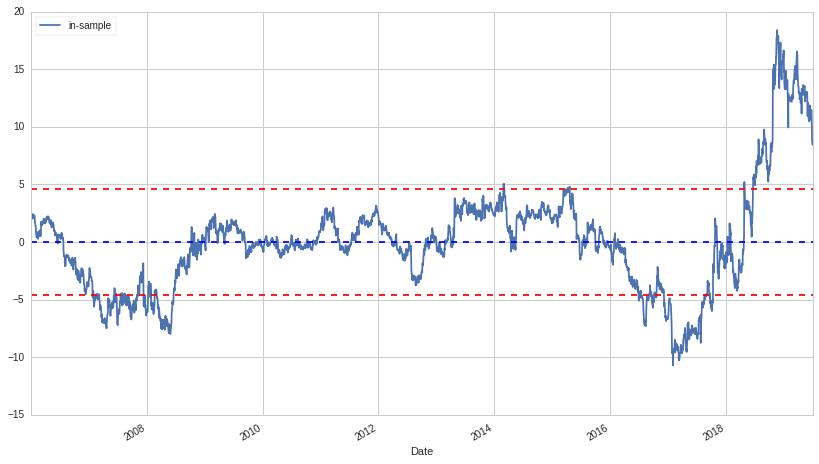

In [19]:
#Mean and 1 std range of the spread
spread.plot();
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='r');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='r');

In [20]:
#Out of sample test using last two years as out of sample, dividing the data
data_oos = get_pricing(symbols(tickers), start_date='2017-1-1', end_date='2019-7-1', 
                       fields='close_price', frequency='daily')
data_oos.columns = [ticker.symbol for ticker in data_oos.columns]
data_oos.index.name = 'Date'

In [21]:
spread_oos = spread.reindex((spread.index).union(data_oos.index))

In [22]:
spread_oos['out-of-sample'] = data_oos[tickers[1]] - beta[0] * data_oos[tickers[0]] - beta[1]

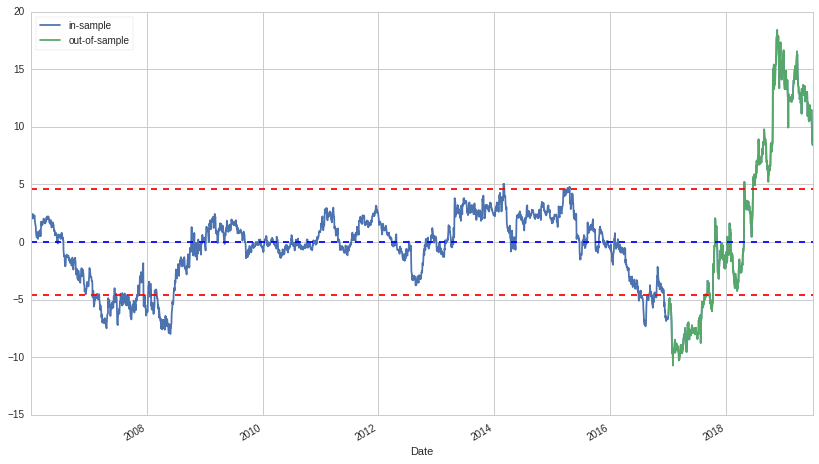

In [23]:
#Looking at out of sample and in sample plot
spread_oos.plot();
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='r');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='r');

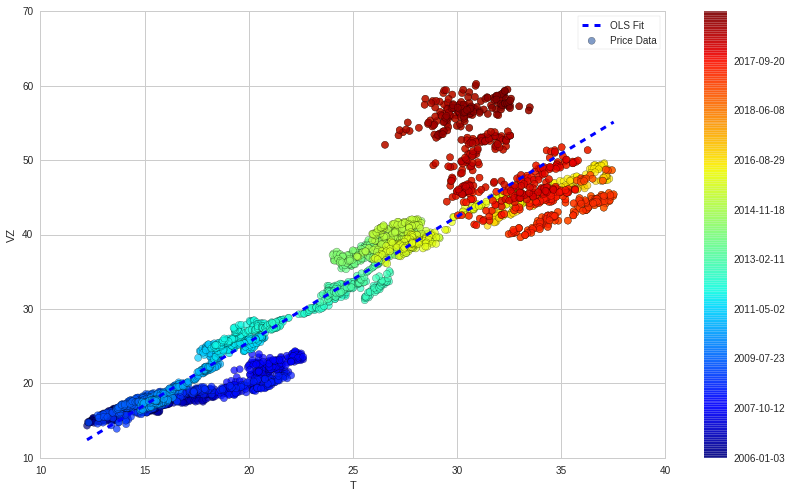

In [24]:
#Append OOS to the end of data and plot
data_all = data.append(data_oos)
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], s=50, c=colors, 
                 cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

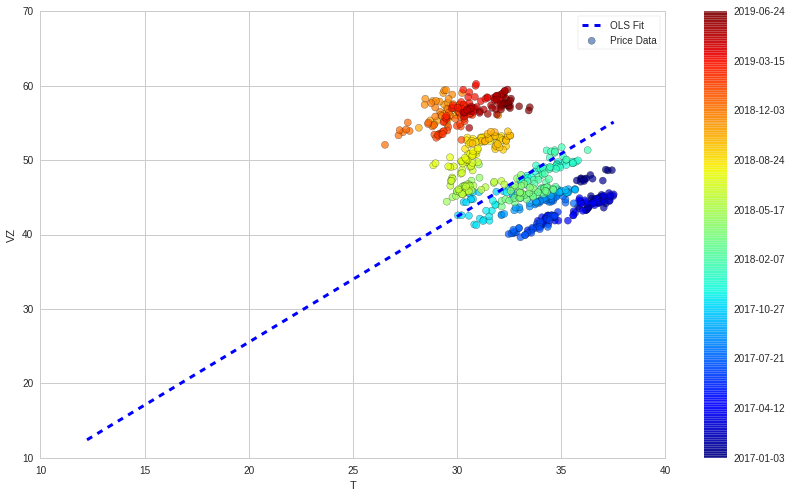

In [107]:
##plot only the out-of sample data
colors = np.linspace(0.1, 1, len(data_oos))
sc = plt.scatter(data_oos[tickers[0]], data_oos[tickers[1]], s=50, c=colors, 
                 cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7, label='Price Data')
plt.plot([x.min()[0], x.max()[0]], y_fit, '--b', linewidth=3, label='OLS Fit')
plt.legend()
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_oos[::len(data_oos)//9].index])
plt.xlabel(tickers[0])
plt.ylabel(tickers[1]);

In [25]:
#Kalman filter set up step
obs_mat = sm.add_constant(data_all[tickers[0]].values, prepend=False)[:, np.newaxis]

# y is 1-dimensional, (alpha, beta) is 2-dimensional
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                  initial_state_mean=np.ones(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=10**2,
                  transition_covariance=0.01**2 * np.eye(2))

In [57]:
obs_mat

array([[[ 12.236,   1.   ]],

       [[ 12.335,   1.   ]],

       [[ 12.35 ,   1.   ]],

       ..., 
       [[ 32.98 ,   1.   ]],

       [[ 33.49 ,   1.   ]],

       [[ 33.44 ,   1.   ]]])

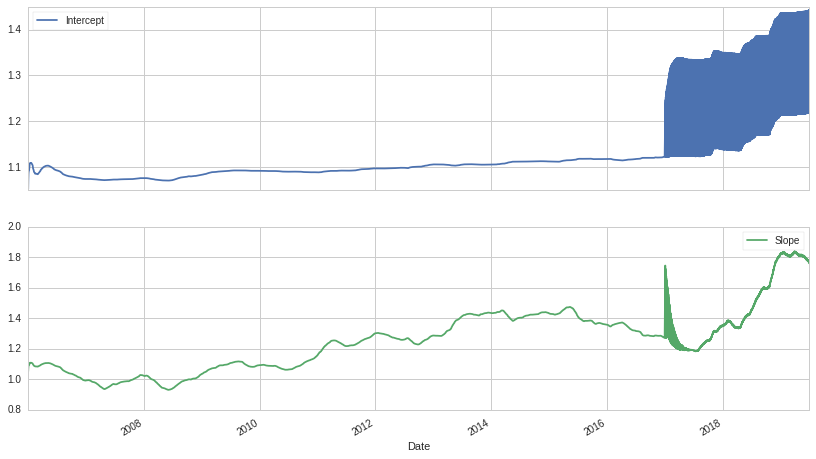

In [27]:
state_means, state_covs = kf.filter(data_all[tickers[1]])
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]},
                       index=data_all.index)
beta_kf.plot(subplots=True);

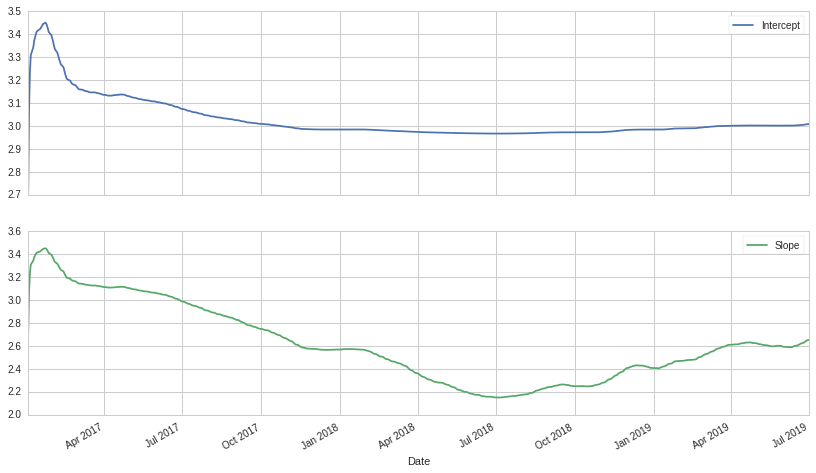

In [109]:
#Looking only at the out of sample 
state_means, state_covs = kf.filter(data_oos[tickers[1]])
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]},
                       index=data_oos.index)
beta_kf.plot(subplots=True);

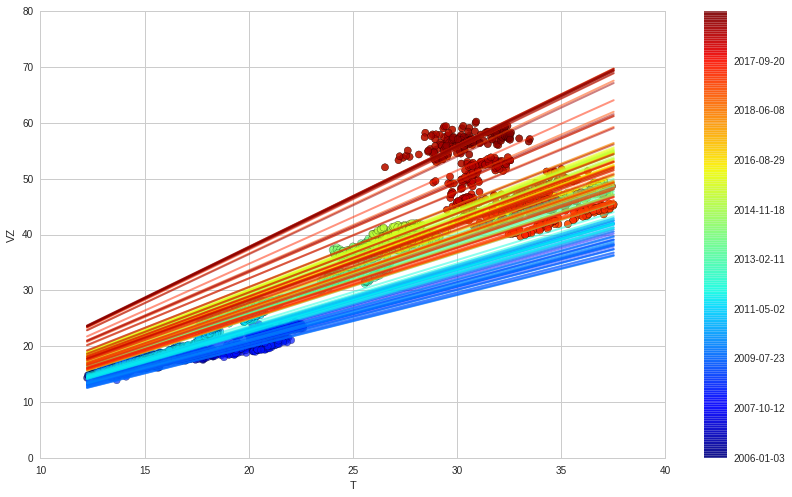

In [28]:
# visualize the correlation between assest prices over time
dates = [str(p.date()) for p in data_all[::len(data_all)/10].index]
colors = np.linspace(0.1, 1, len(data_all))
sc = plt.scatter(data_all[tickers[0]], data_all[tickers[1]], 
                 s=50, c=colors, cmap=plt.get_cmap('jet'), edgecolor='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data_all[::len(data_all)//9].index]);
plt.xlabel(tickers[0])
plt.ylabel(tickers[1])

# add regression lines
step = 25
xi = np.linspace(data_all[tickers[0]].min(), data_all[tickers[0]].max(), 2)
colors_l = np.linspace(0.1, 1, len(state_means[::step]))
for i, b in enumerate(state_means[::step]):
    plt.plot(xi, b[0] * xi + b[1], alpha=.5, lw=2, c=plt.get_cmap('jet')(colors_l[i]))

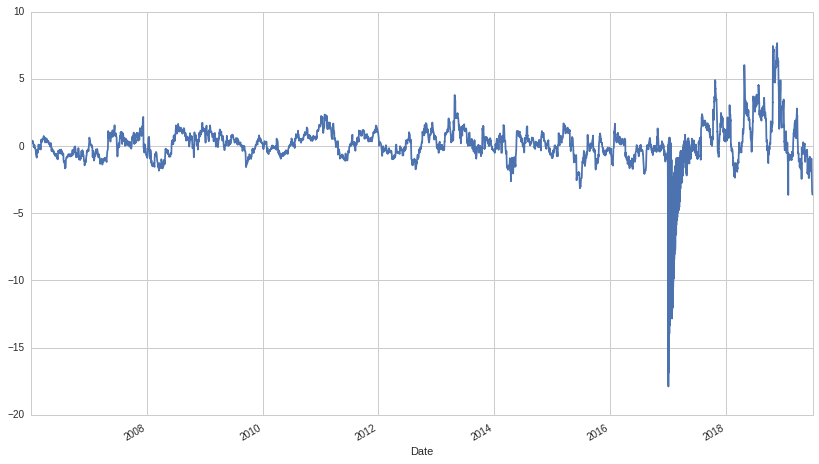

In [29]:
#Finding the spread using kalman filter slope and intercept
spread_kf = data_all[tickers[1]] - data_all[tickers[0]] * beta_kf['Slope'] - beta_kf['Intercept']
spread_kf.plot();

In [30]:
spread_kf.mean()

0.18654499143584893

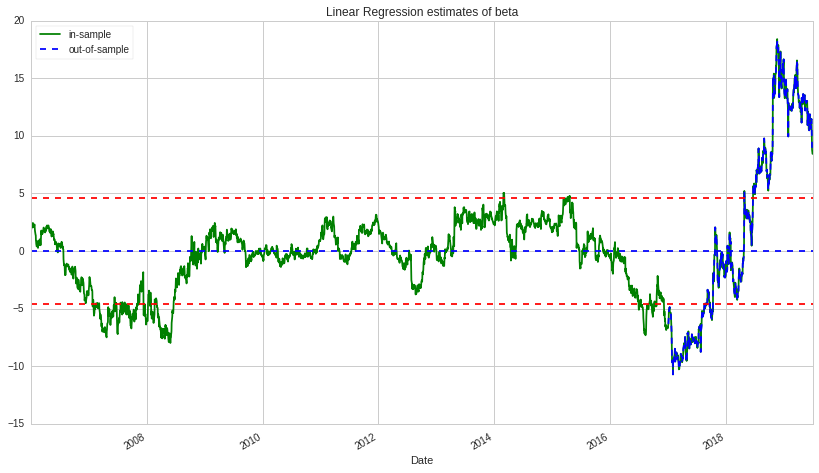

In [110]:
spread_oos.plot(style=['g', '--b', '--y', '--y', 'r']);
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='r');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='r');
plt.legend(loc=0);
plt.title('Linear Regression estimates of beta');

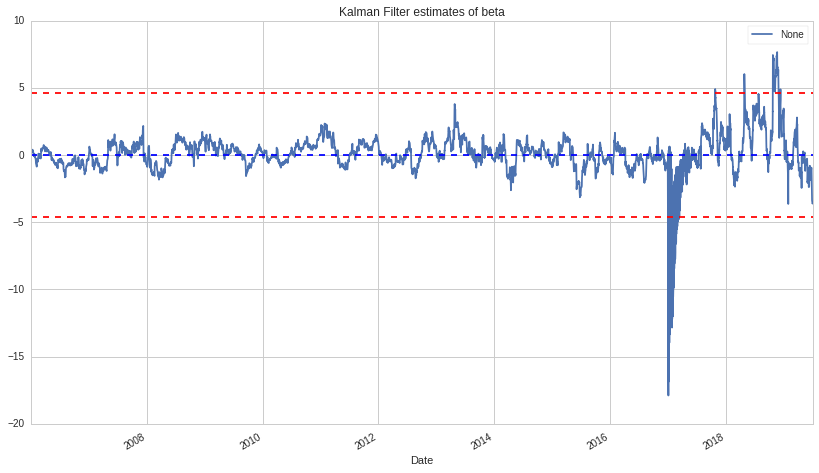

In [34]:
#Kalman filter used a series of measurements observed over time, containing statistical noises and other 
#Inaccuracies and produced estimates that tend to be more accurate than those based on a single measurement
spread_kf.plot()
plt.axhline(spread['in-sample'].mean(), ls = '--', color='b');
plt.axhline(spread['in-sample'].mean() + spread['in-sample'].std(), ls = '--', color='r');
plt.axhline(spread['in-sample'].mean() - spread['in-sample'].std(), ls = '--', color='r');
plt.legend(loc=0);
plt.title('Kalman Filter estimates of beta'); 